In [20]:
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kendalltau, pointbiserialr, mannwhitneyu, theilslopes, linregress, shapiro, kstest, normaltest, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
def check_files(main_dataset):
    if (os.path.isfile(main_dataset)):
        print("Files found!")
    else:
        print("Files not found.")

main_dataset_csv = 'file_level_metrics.csv' #@param {type:"string"}
check_files(main_dataset_csv)
main_dataset_df = pd.read_csv(main_dataset_csv)

Files found!


In [23]:
issue_columns = ['resource_handling_issues', 'assignment_issues',
                 'exception_handling_issues', 'misused_functionality_issues',
                 'synchronization_issues', 'null_pointer_issues', 'logging_issues']

total_issues_column = 'total_issues'

for issue_col in issue_columns:
    main_dataset_df[f'{issue_col}_density'] = (main_dataset_df[issue_col] / main_dataset_df[total_issues_column])
    main_dataset_df[f'{issue_col}_density'] = main_dataset_df[f'{issue_col}_density'].fillna(0)

In [24]:
def check_normality(data, column_name):
    """
    Checks the normality of a given dataset column using different statistical tests.
    """
    shapiro_test = shapiro(data)
    kstest_test = kstest(data, 'norm')
    dagostino_test = normaltest(data)

    print(f"Normality test results for {column_name}:")
    print(f"Shapiro-Wilk Test: Statistics={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3f}")
    print(f"Kolmogorov-Smirnov Test: Statistics={kstest_test[0]:.3f}, p-value={kstest_test[1]:.3f}")
    print(f"D'Agostino's K^2 Test: Statistics={dagostino_test[0]:.3f}, p-value={dagostino_test[1]:.3f}")


    alpha = 0.05

    if shapiro_test[1] > alpha and kstest_test[1] > alpha and dagostino_test[1] > alpha:
        print(f"{column_name} follows a normal distribution.")
    else:
        print(f"{column_name} does not follow a normal distribution.")


check_normality(main_dataset_df['total_issues'], 'total_issues')
check_normality(main_dataset_df['high_td_proba'], 'high_td_proba')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 783485.
  res = hypotest_fun_out(*samples, **kwds)


Normality test results for total_issues:
Shapiro-Wilk Test: Statistics=0.071, p-value=0.000
Kolmogorov-Smirnov Test: Statistics=0.628, p-value=0.000
D'Agostino's K^2 Test: Statistics=3870408.711, p-value=0.000
total_issues does not follow a normal distribution.
Normality test results for high_td_proba:
Shapiro-Wilk Test: Statistics=0.545, p-value=0.000
Kolmogorov-Smirnov Test: Statistics=0.500, p-value=0.000
D'Agostino's K^2 Test: Statistics=347422.250, p-value=0.000
high_td_proba does not follow a normal distribution.


In [25]:
import scipy.stats as st

def calculate_confidence_interval(data, confidence=0.95):
    if not isinstance(data, (pd.Series, np.ndarray)):
        print("Error: Input data must be a pandas Series or a NumPy array.")
        return None

    if not 0 < confidence < 1:
        print("Error: Confidence level must be between 0 and 1.")
        return None

    if len(data) < 2:
        print("Error: Need at least two data points to calculate confidence interval.")
        return None

    mean = np.mean(data)
    std_err = st.sem(data)
    interval = std_err * st.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean - interval, mean + interval

confidence_level = 0.95

total_issues_ci = calculate_confidence_interval(main_dataset_df['total_issues'], confidence_level)
high_td_proba_ci = calculate_confidence_interval(main_dataset_df['high_td_proba'], confidence_level)

print(f"{confidence_level*100:.0f}% Confidence Interval for total_issues: ({total_issues_ci[0]:.2f}, {total_issues_ci[1]:.2f})")
print(f"{confidence_level*100:.0f}% Confidence Interval for high_td_proba: ({high_td_proba_ci[0]:.2f}, {high_td_proba_ci[1]:.2f})")

95% Confidence Interval for total_issues: (18.45, 18.96)
95% Confidence Interval for high_td_proba: (0.11, 0.11)


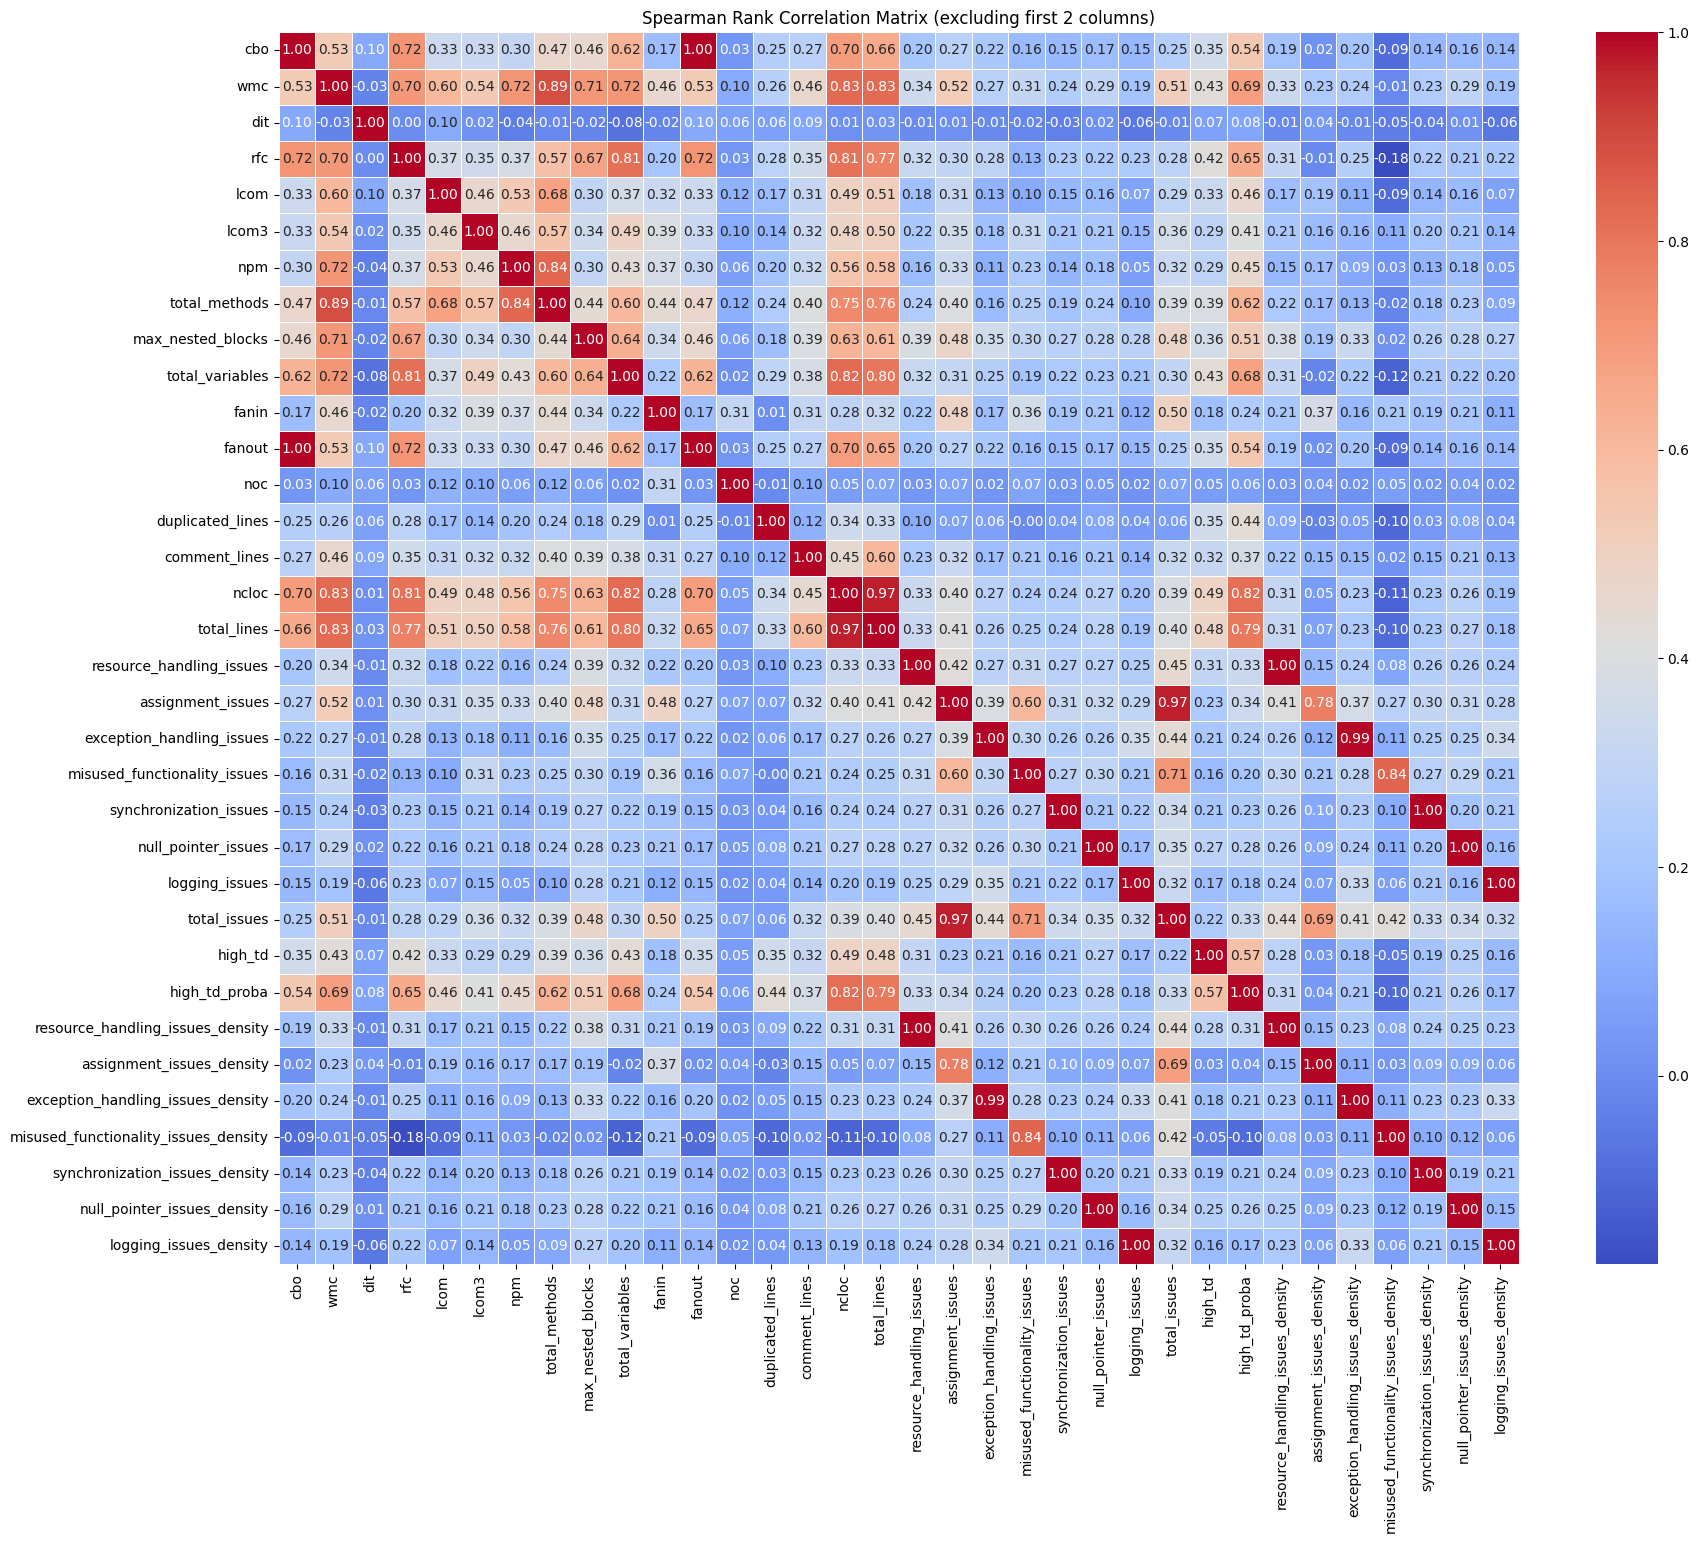

In [26]:
df_subset = main_dataset_df.iloc[:, 2:]

corr_matrix = df_subset.corr(method='spearman')

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Spearman Rank Correlation Matrix (excluding first 2 columns)')
plt.show()

In [27]:
print(main_dataset_df.describe())

                 cbo            wmc            dit            rfc  \
count  783485.000000  783485.000000  783485.000000  783485.000000   
mean        8.513489      17.127681       1.919360      17.681649   
std         9.817549     102.701680       6.779937      32.650384   
min         0.000000       0.000000       1.000000       0.000000   
25%         3.000000       3.000000       1.000000       3.000000   
50%         6.000000       7.000000       1.000000       9.000000   
75%        11.000000      17.000000       2.000000      22.000000   
max      1783.000000   47551.000000    4951.000000    9541.000000   

               lcom          lcom3            npm  total_methods  \
count  7.834850e+05  783485.000000  783485.000000  783485.000000   
mean   1.250788e+02       0.394137       6.335061       8.292554   
std    1.205533e+04       0.362187      16.775991      18.919975   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    0.000000e+00       0.000000    

Selected Features: Index(['high_td_proba'], dtype='object')
Mean Squared Error: 13982.239364061652
R-squared: 0.04544192829712124


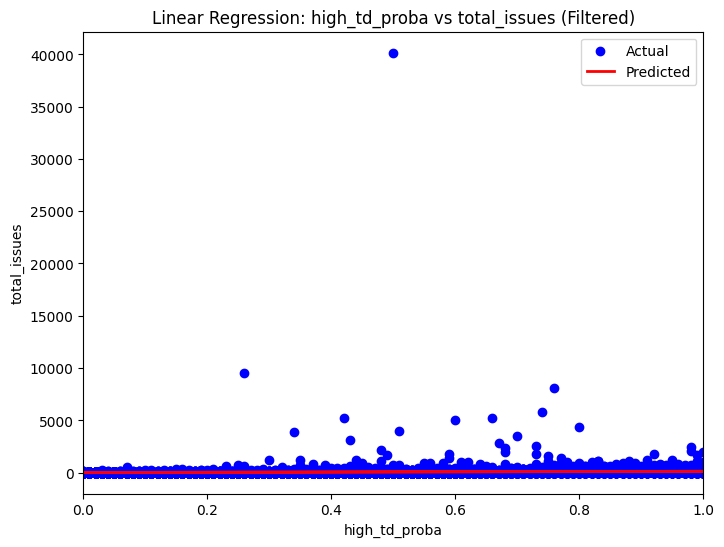

Mean Squared Error (reversed): 0.05011446368400915
R-squared (reversed): 0.04396221140698853


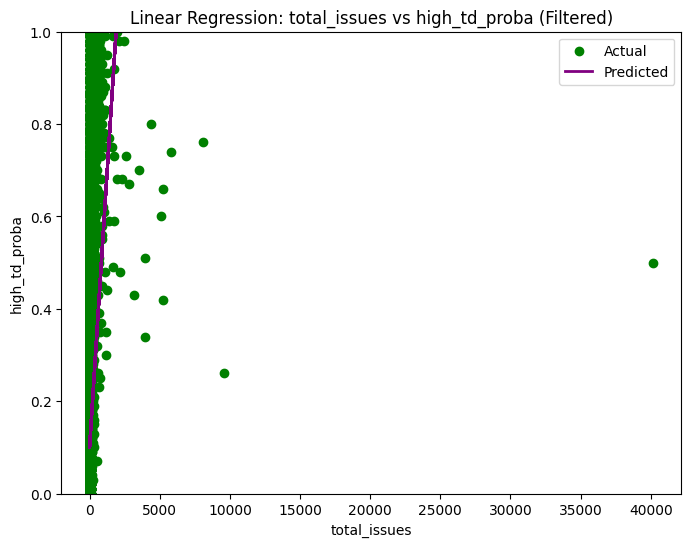

In [28]:
filtered_df = main_dataset_df[main_dataset_df['high_td_proba'].between(0, 1)]

X = filtered_df[['high_td_proba']]
y = filtered_df['total_issues']

selector = SelectKBest(score_func=f_regression, k='all')
X_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]
print(f"Selected Features: {selected_feature_names}")

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('high_td_proba')
plt.ylabel('total_issues')
plt.title('Linear Regression: high_td_proba vs total_issues (Filtered)')
plt.xlim(0, 1)
plt.legend()
plt.show()

X = filtered_df[['total_issues']]
y = filtered_df['high_td_proba']

selector = SelectKBest(score_func=f_regression, k='all')
X_selected = selector.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (reversed): {mse}")
print(f"R-squared (reversed): {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='green', label='Actual')
plt.plot(X_test, y_pred, color='purple', linewidth=2, label='Predicted')
plt.xlabel('total_issues')
plt.ylabel('high_td_proba')
plt.title('Linear Regression: total_issues vs high_td_proba (Filtered)')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [29]:
def remove_outliers_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return data[(data >= lower_bound) & (data <= upper_bound)]

for column in main_dataset_df.select_dtypes(include=np.number).columns:
  filtered_data = remove_outliers_iqr(main_dataset_df[column])
  print(f"Column: {column}")
  print(f"Min without outliers: {filtered_data.min()}")
  print(f"Max without outliers: {filtered_data.max()}")
  print("-" * 30)


Column: cbo
Min without outliers: 0
Max without outliers: 23
------------------------------
Column: wmc
Min without outliers: 0
Max without outliers: 38
------------------------------
Column: dit
Min without outliers: 1
Max without outliers: 3
------------------------------
Column: rfc
Min without outliers: 0
Max without outliers: 50
------------------------------
Column: lcom
Min without outliers: 0
Max without outliers: 37
------------------------------
Column: lcom3
Min without outliers: 0.0
Max without outliers: 1.0
------------------------------
Column: npm
Min without outliers: 0
Max without outliers: 16
------------------------------
Column: total_methods
Min without outliers: 0
Max without outliers: 19
------------------------------
Column: max_nested_blocks
Min without outliers: 0
Max without outliers: 5
------------------------------
Column: total_variables
Min without outliers: 0
Max without outliers: 32
------------------------------
Column: fanin
Min without outliers: 0
Ma

In [30]:
numerical_df = main_dataset_df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr(method='spearman')

corr_matrix = corr_matrix.mask(np.equal(*np.indices(corr_matrix.shape)))

correlation_pairs = corr_matrix.unstack()

sorted_correlations = correlation_pairs.sort_values(ascending=False)

high_correlation_threshold = 0.5
moderate_correlation_threshold = 0.3
low_correlation_threshold = 0.2

high_correlations = {}
moderate_correlations = {}
low_correlations = {}

for (var1, var2), correlation in sorted_correlations.items():
  if abs(correlation) >= high_correlation_threshold:
    if var1 not in high_correlations:
      high_correlations[var1] = []
    high_correlations[var1].append((var2, correlation))
  elif abs(correlation) >= moderate_correlation_threshold:
    if var1 not in moderate_correlations:
      moderate_correlations[var1] = []
    moderate_correlations[var1].append((var2, correlation))
  elif abs(correlation) >= low_correlation_threshold:
    if var1 not in low_correlations:
      low_correlations[var1] = []
    low_correlations[var1].append((var2, correlation))

print("High Correlations:")
for var, correlations in high_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")

print("\nModerate Correlations:")
for var, correlations in moderate_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")


print("\nLow Correlations:")
for var, correlations in low_correlations.items():
  print(f"{var}:")
  for related_var, correlation_value in correlations:
    print(f"  - {related_var}: {correlation_value:.3f}")


High Correlations:
fanout:
  - cbo: 0.999
  - rfc: 0.721
  - ncloc: 0.696
  - total_lines: 0.655
  - total_variables: 0.621
  - high_td_proba: 0.541
  - wmc: 0.528
cbo:
  - fanout: 0.999
  - rfc: 0.722
  - ncloc: 0.696
  - total_lines: 0.655
  - total_variables: 0.622
  - high_td_proba: 0.541
  - wmc: 0.528
logging_issues:
  - logging_issues_density: 0.999
logging_issues_density:
  - logging_issues: 0.999
null_pointer_issues_density:
  - null_pointer_issues: 0.998
null_pointer_issues:
  - null_pointer_issues_density: 0.998
synchronization_issues_density:
  - synchronization_issues: 0.998
synchronization_issues:
  - synchronization_issues_density: 0.998
resource_handling_issues_density:
  - resource_handling_issues: 0.997
resource_handling_issues:
  - resource_handling_issues_density: 0.997
exception_handling_issues_density:
  - exception_handling_issues: 0.994
exception_handling_issues:
  - exception_handling_issues_density: 0.994
ncloc:
  - total_lines: 0.971
  - wmc: 0.830
  - total_

In [31]:
dataset_lower = main_dataset_df[main_dataset_df['total_issues'] < 21]
dataset_upper = main_dataset_df[main_dataset_df['total_issues'] >= 21]

correlation_lower, p_value_lower = spearmanr(dataset_lower['total_issues'], dataset_lower['high_td_proba'])
print(f"Spearman correlation (Lower): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
  print("The correlation is statistically significant for the lower threshold dataset.")
else:
  print("The correlation is not statistically significant for the lower threshold dataset.")


correlation_upper, p_value_upper = spearmanr(dataset_upper['total_issues'], dataset_upper['high_td_proba'])
print(f"Spearman correlation (Upper): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
  print("The correlation is statistically significant for the upper threshold dataset.")
else:
  print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower): -0.178, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper): 0.757, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.


In [32]:
dataset_lower_proba = main_dataset_df[main_dataset_df['high_td_proba'] < 0.06]
dataset_upper_proba = main_dataset_df[main_dataset_df['high_td_proba'] >= 0.06]

correlation_lower, p_value_lower = spearmanr(dataset_lower_proba['total_issues'], dataset_lower_proba['high_td_proba'])
print(f"Spearman correlation (Lower Proba): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
    print("The correlation is statistically significant for the lower threshold dataset.")
else:
    print("The correlation is not statistically significant for the lower threshold dataset.")

correlation_upper, p_value_upper = spearmanr(dataset_upper_proba['total_issues'], dataset_upper_proba['high_td_proba'])
print(f"Spearman correlation (Upper Proba): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
    print("The correlation is statistically significant for the upper threshold dataset.")
else:
    print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower Proba): 0.192, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper Proba): 0.361, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.


In [33]:
dataset_lower_lines = main_dataset_df[main_dataset_df['total_lines'] < 192]
dataset_upper_lines = main_dataset_df[main_dataset_df['total_lines'] >= 192]

correlation_lower_lines, p_value_lower_lines = spearmanr(dataset_lower_lines['total_issues'], dataset_lower_lines['high_td_proba'])
print(f"Spearman correlation (Lower Lines): {correlation_lower_lines:.3f}, p-value: {p_value_lower_lines:.3f}")

alpha = 0.05
if p_value_lower_lines < alpha:
    print("The correlation is statistically significant for the lower threshold dataset (total_lines).")
else:
    print("The correlation is not statistically significant for the lower threshold dataset (total_lines).")

correlation_upper_lines, p_value_upper_lines = spearmanr(dataset_upper_lines['total_issues'], dataset_upper_lines['high_td_proba'])
print(f"Spearman correlation (Upper Lines): {correlation_upper_lines:.3f}, p-value: {p_value_upper_lines:.3f}")

if p_value_upper_lines < alpha:
    print("The correlation is statistically significant for the upper threshold dataset (total_lines).")
else:
    print("The correlation is not statistically significant for the upper threshold dataset (total_lines).")

Spearman correlation (Lower Lines): 0.190, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset (total_lines).
Spearman correlation (Upper Lines): 0.344, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset (total_lines).


In [34]:
main_dataset_df['total_issues_density'] = main_dataset_df['total_issues'] / main_dataset_df['total_lines']
main_dataset_df['total_issues_density'] = main_dataset_df['total_issues_density'].fillna(0)

dataset_lower_proba = main_dataset_df[main_dataset_df['high_td_proba'] < 0.06]
dataset_upper_proba = main_dataset_df[main_dataset_df['high_td_proba'] >= 0.06]

correlation_lower, p_value_lower = spearmanr(dataset_lower_proba['total_issues_density'], dataset_lower_proba['high_td_proba'])
print(f"Spearman correlation (Lower Proba): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
    print("The correlation is statistically significant for the lower threshold dataset.")
else:
    print("The correlation is not statistically significant for the lower threshold dataset.")

correlation_upper, p_value_upper = spearmanr(dataset_upper_proba['total_issues_density'], dataset_upper_proba['high_td_proba'])
print(f"Spearman correlation (Upper Proba): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
    print("The correlation is statistically significant for the upper threshold dataset.")
else:
    print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower Proba): 0.081, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper Proba): 0.113, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.


In [35]:
dataset_lower = main_dataset_df[main_dataset_df['total_issues'] < 21]
dataset_upper = main_dataset_df[main_dataset_df['total_issues'] >= 21]

correlation_lower, p_value_lower = spearmanr(dataset_lower['total_issues_density'], dataset_lower['high_td_proba'])
print(f"Spearman correlation (Lower): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
    print("The correlation is statistically significant for the lower threshold dataset.")
else:
    print("The correlation is not statistically significant for the lower threshold dataset.")

correlation_upper, p_value_upper = spearmanr(dataset_upper['total_issues_density'], dataset_upper['high_td_proba'])
print(f"Spearman correlation (Upper): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
    print("The correlation is statistically significant for the upper threshold dataset.")
else:
    print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower): -0.290, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper): -0.164, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.


In [36]:
dataset_lower_lines = main_dataset_df[main_dataset_df['total_lines'] < 192]
dataset_upper_lines = main_dataset_df[main_dataset_df['total_lines'] >= 192]

correlation_lower_lines, p_value_lower_lines = spearmanr(dataset_lower_lines['total_issues_density'], dataset_lower_lines['high_td_proba'])
print(f"Spearman correlation (Lower Lines): {correlation_lower_lines:.3f}, p-value: {p_value_lower_lines:.3f}")

alpha = 0.05
if p_value_lower_lines < alpha:
    print("The correlation is statistically significant for the lower threshold dataset (total_lines).")
else:
    print("The correlation is not statistically significant for the lower threshold dataset (total_lines).")

correlation_upper_lines, p_value_upper_lines = spearmanr(dataset_upper_lines['total_issues_density'], dataset_upper_lines['high_td_proba'])
print(f"Spearman correlation (Upper Lines): {correlation_upper_lines:.3f}, p-value: {p_value_upper_lines:.3f}")

if p_value_upper_lines < alpha:
    print("The correlation is statistically significant for the upper threshold dataset (total_lines).")
else:
    print("The correlation is not statistically significant for the upper threshold dataset (total_lines).")

Spearman correlation (Lower Lines): 0.095, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset (total_lines).
Spearman correlation (Upper Lines): 0.143, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset (total_lines).


In [37]:
dataset_lower = main_dataset_df[main_dataset_df['total_issues_density'] < 0.093483]
dataset_upper = main_dataset_df[main_dataset_df['total_issues_density'] >= 0.093483]

correlation_lower, p_value_lower = spearmanr(dataset_lower['total_issues_density'], dataset_lower['high_td_proba'])
print(f"Spearman correlation (Lower): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
  print("The correlation is statistically significant for the lower threshold dataset.")
else:
  print("The correlation is not statistically significant for the lower threshold dataset.")

correlation_upper, p_value_upper = spearmanr(dataset_upper['total_issues_density'], dataset_upper['high_td_proba'])
print(f"Spearman correlation (Upper): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
  print("The correlation is statistically significant for the upper threshold dataset.")
else:
  print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower): -0.204, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper): 0.246, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.


In [38]:
dataset_lower_proba = main_dataset_df[main_dataset_df['high_td_proba'] < 0.06]
dataset_upper_proba = main_dataset_df[main_dataset_df['high_td_proba'] >= 0.06]

correlation_lower, p_value_lower = spearmanr(dataset_lower_proba['total_issues_density'], dataset_lower_proba['high_td_proba'])
print(f"Spearman correlation (Lower Proba): {correlation_lower:.3f}, p-value: {p_value_lower:.3f}")

alpha = 0.05
if p_value_lower < alpha:
    print("The correlation is statistically significant for the lower threshold dataset.")
else:
    print("The correlation is not statistically significant for the lower threshold dataset.")

correlation_upper, p_value_upper = spearmanr(dataset_upper_proba['total_issues_density'], dataset_upper_proba['high_td_proba'])
print(f"Spearman correlation (Upper Proba): {correlation_upper:.3f}, p-value: {p_value_upper:.3f}")

if p_value_upper < alpha:
    print("The correlation is statistically significant for the upper threshold dataset.")
else:
    print("The correlation is not statistically significant for the upper threshold dataset.")

Spearman correlation (Lower Proba): 0.081, p-value: 0.000
The correlation is statistically significant for the lower threshold dataset.
Spearman correlation (Upper Proba): 0.113, p-value: 0.000
The correlation is statistically significant for the upper threshold dataset.
